# Project: Investigate a No-Show Appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#ma">Main Attributes</a></li>
<li><a href="#age">Age</a></li>
    <li><a href="#time">Time</a></li> 
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The given dataset includes 300k medical appointments of the public healthcare of the capital city of Espirito Santo State - Vitoria - Brazil. In it includes 15 variables. I explore these variables and their impact on attendance. Variables that will need to further investigated in the future include gender and neigborhood. I will study the affect of an SMS being sent, Alcoholism, Scholarship, Handicap, Hipertension, Diabetes, and Elapsed Time between scheudling on the the attendance of patients. I also studied the affect of age on attendance. The following notebook will walk you through data cleansing, visualizations, and conclusions.


<a id='wrangling'></a>
## Data Wrangling

Here the data is loaded. The data seems already very clean. It currently has no duplicates, has logical data types, and meaningful names. The handicap column however was not binary like the rest of the variables and rather was a count on the number of handicaps. For consistency, it was converted to a binary form. I also converted the No-Show columns to binary. If the patient went to the appointment, it would be marked as a 0 otherwise it would marked as 1. Additionally, the scheduled day and appointment day were both stored as strings. I converted these to datetime objects and added a derived column called elapsed time which indicates the time between the appointment and scheduled day. When doing this I realized some appointments are scheduled and attended on the same day. I removed these from the dataset since the patient never risked missing the appointment. 



First we will import all libraries required for this analysis.

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime 

%matplotlib inline
# All Import Statements required for the code


We will load the data and preview the set to see what we are working with.

In [32]:
# Loaded and previewed data
src_data = pd.read_csv('appts_missed.csv')
src_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


The table presents 15 column each with data about our patient. We note that many attributes are binary. We will next look at the size of our dataset. 

In [33]:
#Scope of our data size
src_data.shape

(110527, 14)

The size seem large and suitable for analysis. We will check next that the data has no null elements.

In [34]:
#Check for null elements
src_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


The data has no null elements, we will now check for duplicates.

In [35]:
#Check for duplicates
src_data.duplicated()

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
110497    False
110498    False
110499    False
110500    False
110501    False
110502    False
110503    False
110504    False
110505    False
110506    False
110507    False
110508    False
110509    False
110510    False
110511    False
110512    False
110513    False
110514    False
110515    False
110516    False
110517    False
110518    False
110519    False
110520    False
110521    False
110522    False
110523    False
110524    False
110525    False
110526    False
Length: 110527, dtype: b

There are no duplicates in the dataset. We will now check for logical datatypes.

In [36]:
#Check for logical data types. The Scheduled Day and Appointment Day would be converted into datetime objects.
src_data.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

The data types seem to work. However from Kaggle we learned that the Handicap is not binary like the rest of the attributes, we fixt that below. We also note that dates are stored as strings, we will convert those to datetime objects. We also will convert No-show to binary rather than using No and Yes strings.

In [37]:
def to_binary(intx):
    if intx == 0:
        return 0
    return 1

src_data['Handcap'] = src_data.apply(lambda x:to_binary(x['Handcap']), axis = 1)
src_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We succefully converted handicap to binary, we will do the same the No-Show column.

In [38]:
#To find correlation easier I changed the No-Show column to integers
def conversion(str):
    if str == "No":
        return 0
    return 1

src_data['No-show'] = src_data.apply(lambda x:conversion(x['No-show']), axis = 1)
src_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0


We succesfully converted the No-Show column, we will convert the Scheduleday and Appointment Day columns to datetime objects.

In [39]:
#Change the String Data Type of Dates to datetime
src_data['ScheduledDay'] = src_data.apply(lambda x: datetime.strptime(x['ScheduledDay'],'%Y-%m-%dT%H:%M:%SZ'), axis = 1)
src_data['AppointmentDay'] = src_data.apply(lambda x: datetime.strptime(x['AppointmentDay'],'%Y-%m-%dT%H:%M:%SZ'), axis = 1)
src_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0


We converted the columns to datetime objects. We will now create a derived column from the two columns called ElapsedTime. This will be the time elapsed between appointment and scheduled dates.

In [40]:
#Add a column to describe another variable
src_data['ElapsedTime'] = src_data['AppointmentDay'] - src_data['ScheduledDay'] 
src_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ElapsedTime
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,-1 days +05:21:52
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,-1 days +07:51:33
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,-1 days +07:40:56
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,-1 days +06:30:29
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,-1 days +07:52:37


Some of the column have a negative time elapsed. This means that omeone made the appointment they day of. This entails that it was probably a walk in and they did not risk the chance of ever missing the appointment. For that reason these results will be dropped

In [41]:
#After the added column the times elapsed were 0. This was a problem.
#My interpretation of the data is that if someone made the appointment they day of 
#it was probably a walk in and they did not risk the chance of ever missing the appointment.
#For that reason these results will be dropped
src_data.dtypes
src_data = src_data[src_data.ElapsedTime == abs(src_data.ElapsedTime)]
src_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ElapsedTime
5,9.598513e+13,5626772,F,2016-04-27 08:36:51,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,0,1 days 15:23:09
6,7.336882e+14,5630279,F,2016-04-27 15:05:12,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,1,1 days 08:54:48
7,3.449833e+12,5630575,F,2016-04-27 15:39:58,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,1,1 days 08:20:02
9,7.812456e+13,5629123,F,2016-04-27 12:48:25,2016-04-29,19,CONQUISTA,0,0,0,0,0,0,0,1 days 11:11:35
10,7.345362e+14,5630213,F,2016-04-27 14:58:11,2016-04-29,30,NOVA PALESTINA,0,0,0,0,0,0,0,1 days 09:01:49


We succesfully dropped all walk in appointments. We will verify the dataset is still sufficiently large.

In [42]:
#verify the size of the dataset is still large
src_data.shape

(71959, 15)

The dataset is sufficiently large and exploratory data analysis can begin.

<a id='eda'></a>
## Exploratory Data Analysis

We will begin by finding correlations between the No-show column and the main attributes.

In [43]:
# First we conduct a correlation across the entire dataset
src_data.corr().iloc[1:-1,-1]

AppointmentID   -0.065723
Age             -0.101042
Scholarship      0.045687
Hipertension    -0.056859
Diabetes        -0.022412
Alcoholism       0.019864
Handcap         -0.008930
SMS_received    -0.020631
Name: No-show, dtype: float64

Nothing seems to strike out with a significant correlation. We will next examine the overal turnout rate, to have an understanding of the entire dataset.

Text(0.5,1,'Count of Missed and Attended Appointments')

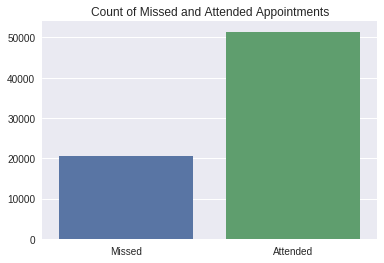

In [44]:
#A look at the overal turnout rate
total_arr =  [src_data['No-show'].sum(),src_data['No-show'].count()-src_data['No-show'].sum()]
ax = sns.barplot(x=['Missed','Attended'],y=total_arr)
ax.set_title('Count of Missed and Attended Appointments')


It would seem as though it is around 3 times as likely that a patient attends their appointment than misses it. This gives us a basic understanding of the severity of the problem. We will now begin to understand the main attributes to that problem.

<a id='ma'></a>
### What are the main indications that a patient might miss their appointment?

We will first create a display of the number of times an attribute is present in the missed and attended data pool. This information will shows us the most common characteristics of a patient who missed/attended their meeting.

Text(0,0.5,'Count')

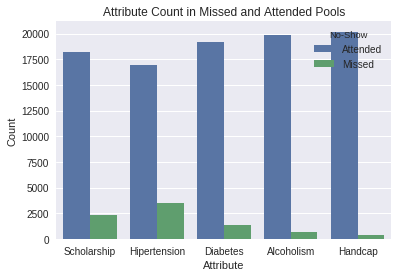

In [45]:
#A display of the count of no show appointment and attended appointments per attribute
attribute_count_df = pd.DataFrame()
for name in src_data.columns[7:-3]:
    attribute_count_df[name] = src_data.groupby(name)['No-show'].sum()
    
attribute_count_df.index.names = ['No-Show']
attribute_count_df['No-Show'] = ['Attended','Missed']
attribute_count_df = pd.melt(attribute_count_df, id_vars=['No-Show'],var_name="Attribute", value_name="Count")
ax = sns.barplot(x='Attribute', y='Count', hue='No-Show', data=attribute_count_df)
ax.set_title('Attribute Count in Missed and Attended Pools')
ax.set_ylabel('Count')

The bargraph above shows us a few important characterstics. Primarily that hipertension and an SMS_Received are the two most common attributes in a missed patient profile. However it is important to note that this by no means tells us a correlation or causation. This graph merely is method to estimate the most common attributes. We will next examine the correlation between these attributes and attendance.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


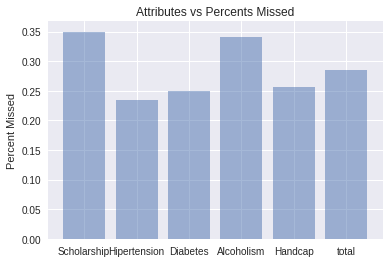

In [46]:
"""A plot for basic distributions"""
def plot(distribution,label,title):
    y_pos = np.arange(len(distribution.index))

    plt.bar(y_pos, distribution.values, align='center', alpha=0.5)
    plt.xticks(y_pos, distribution.index)
    plt.ylabel(label)
    plt.title(title)
    plt.show()
#A better represesntation of the importance of attributes. The bar graph shows the percents missed when the attribute is present.
attribute_percent_df = pd.DataFrame()
for name in src_data.columns[7:-3]:
    filtered = src_data[src_data[name] == 1]
    attribute_percent_df[name] = filtered[src_data['No-show'] == 1 ].count()/filtered.count()
    
attribute_percent_df['total'] = src_data['No-show'].sum()/src_data['No-show'].count()
attribute_percent_df = attribute_percent_df.iloc[-1]
plot(attribute_percent_df,'Percent Missed','Attributes vs Percents Missed')


The plot above shows us the correlation between the attribtues and the percent missed. Each bar is the percent of meetings missed with the attribute specified is present. We see from here that the Scholarship and Alcoholism have a significantly higher percent missed thatn the norm. We will next go on to study a non-binary attribute: age.

<a id='age'></a>
### How Does Age Influence Missing Appointments?

We will plot the number of appointments missed by percent per age. Ages above 100 will be dropped because of lack of sufficient data.

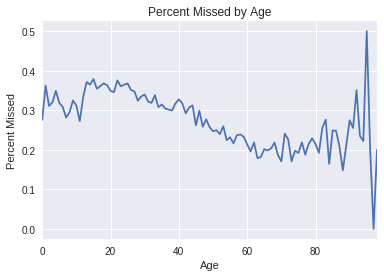

In [47]:
age_distribution = src_data.groupby('Age')['No-show'].sum()/src_data.groupby('Age')['No-show'].count()
age_distribution = age_distribution.drop([100,102,115]) #Used to delete a few datapoints without much data
ax = age_distribution.plot(label = 'Percent Missed')
ax.set_ylabel('Percent Missed')
ax.set_title('Percent Missed by Age')
ax

The outputted graph seems incredibly noisy and for clarity we conduct a moving average to smoothen out the curve.

Text(0.5,1,'Percent Missed by Age')

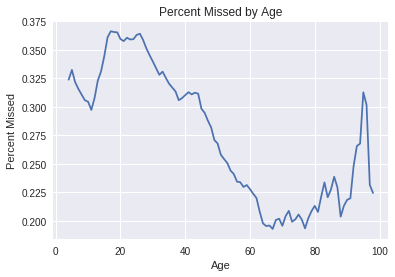

In [48]:
#In order to smooth the curve we have taken advantage of moving averages
age_df = pd.DataFrame({'Age':age_distribution.index, 'percent':age_distribution.values})
age_df['MA'] = age_df['percent'].rolling(window=5).mean()
plt.plot(age_df['Age'],age_df['MA'],label='Percent Missed')
plt.ylabel('Percent Missed')
plt.xlabel('Age')
plt.title('Percent Missed by Age')

The smoothened graph shows us the a high percent missed at infant age then decreasing towards the age of independency. At the age of independency, the graph spikes up and progressively decreases up to the age of 70 and begins to rise from then on. We will now look at another non binary attribute, the elapsed time. 

<a id='time'></a>
### Does the time between scheduled and appointment data influence a patient missing their appointment?

To begin our analysis we will first convert and categorize elapsed time. We will covert the time delta objects into seconds and split them up into quartiles of short wait times to long wait times.

In [49]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
src_data['ElapsedTime'] = src_data.apply(lambda x: x['ElapsedTime'].seconds,axis=1)
src_data['ElapsedTime'].describe()

count    71959.000000
mean     44736.208841
std      11782.300616
min       9145.000000
25%      34717.000000
50%      46852.000000
75%      55155.500000
max      63327.000000
Name: ElapsedTime, dtype: float64

With out our ranges of the elapsed time quartiles, we can now plot to understand the the correlation.

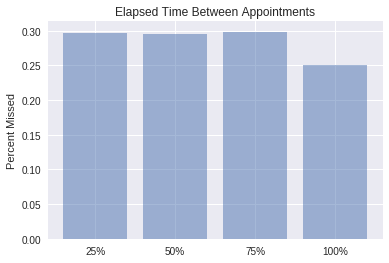

In [50]:
bin_edges = [0 ,34717.000000 ,46852.000000 ,55155.500000 ,63327.000000] # Fill in this list with five values you just found
bin_names = ['25%' ,'50%' ,'75%' ,'100%' ] # Name each time level category
src_data['time_levels'] = pd.cut(src_data['ElapsedTime'], bin_edges, labels=bin_names)
time_distribution = src_data.groupby('time_levels')['No-show'].sum()/src_data.groupby('time_levels')['No-show'].count()

plot(time_distribution,'Percent Missed','Elapsed Time Between Appointments')

The graph above shows how the different quartiles of elapsed time correlate with percent missed. We see that the the 75% of shortest wait times have around the same percent missed. When we reach that highest quartile, there is a significant drop in percent missed. 

<a id='conclusions'></a>
## Conclusions

### Main Attributes:

All variable had a relatively low correlation between missing appointments. However notably Alcoholism and Scholarship have higher percent appointments missed than normal. Hypertension, diabetes, handicap, and SMS_Received have a lower percent missed than the typical. These make intuitive sense. A more severe problem is likely to be overlooked by a patient. 

### Age:

The probability a patient will miss is correlated with age. From 0-18, the patient become less likely to miss their appointment. This is most likely that there attendance is dependant on their guardians. But at the age of independence, there is a spike in missed attendance which which gradually reduces to the age of 70. From here on missed attendance begins to climbs. This implies that one should be careful for patients that are between the ages of 20-40. 

### Elapsed Time:

There was also not a signifcant correlation between time elapsed between scheduling and attending and attendance. However in the highest quartile there is a notable drop in missed ttendance. This implies that for optimum attendance, the turnaround between schedule and turnaround should be longer. It is also important to note that the SMS_Received proves to be futile and stronger reminding measure must be implemented.   

### Limitations

Although this dataset was rather comprehensive, there were a few limitations in it. For example, for minors, it is likely that a parent placed the appointment and really they are charged with remembering dates. Infromation about the parent could be useful to this dataset. There is also a limitation on what the SMS_Received column provides. If it denoted when the SMS was received and what content was sent, recommendation on when to send SMSes could be provided. All the column are also binary. An indication of the severity of the column could prove to be very useful.


In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0